processing start
calculation time : 6.1234459877


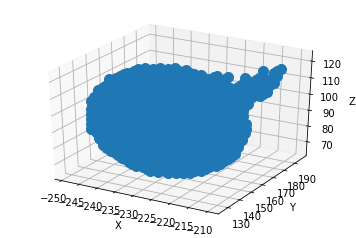

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import PIL
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
import time

def projection(x,y,z,ART):
    # projection calculation
    # x,y,z : 3d position
    # ART   : combined matrix of A,R,T
    
    temp = ART.dot([x,y,z,1])
    uv = temp[:-1]/temp[-1]  
    uv = np.int64(uv)
    return uv

def is_obj(x,y,z,ART,sil):
    # evaluate the 3d position(x,y,z)
    # x,y,z : 3d position
    # ART   : combined matrix of A,R,T
    # sil   : silette immage
    uv = projection(x,y,z,ART)
    try:
        return sil[uv[1],uv[0]]
    except:
        return 0#if the index is out, it is regarded that there is no silette

#load camera parameters
data=sio.loadmat('./data/cam.mat')
cam=data['cam']
cam_list=[]
for k in range(12):
    temp={'A':cam[0][k][0][0][0],
         'R':cam[0][k][0][0][1],
         'T':cam[0][k][0][0][2]}
    cam_list.append(temp)


#load silett
for k in range(1,13):
    sil=np.asarray(PIL.Image.open('./data/sil{0:02d}.png'.format(k)))
    cam_list[k-1].update({'sil':sil[:,:,0]/255})

# reconstruction resolution (cm).
R = 3;

# reconstruction range
xran = np.array([-300,-200])
yran = np.array([100,250])
zran = np.array([50,150])

# x,y,z positions of each voxel
x_pos= np.arange(xran[0],xran[1]+R,R)
y_pos= np.arange(yran[0],yran[1]+R,R)
z_pos= np.arange(zran[0],zran[1]+R,R)

# length of voxels along each cordinate
xlen=len(x_pos)
ylen=len(y_pos)
zlen=len(z_pos)

# initial voxel condition
# one means the voxel can include object
# zero means the voxel must be empty
vox=np.ones([xlen,ylen,zlen])


# main processing part
t = time.time()
print('processing start')
for k in range(len(cam_list)):

    #prepare
    A=cam_list[k]['A']
    R=cam_list[k]['R']
    T=cam_list[k]['T']
    sil = cam_list[k]['sil']

    #combined matrix of A,R,T
    RT=np.vstack([np.hstack([R,T]),np.zeros([1,4])])
    A0=np.hstack([A,np.zeros([3,1])])
    ART=A0.dot(RT) 
    
    #is each voxel ok? 
    vox_k=[is_obj(x,y,z,ART,sil) for x,y,z in product(x_pos,y_pos,z_pos)]
    vox_k=np.array(vox_k).reshape(xlen,ylen,zlen)
    
    #update voxel condition
    vox *= vox_k
print('calculation time : {}'.format(time.time() - t))

#transform index to voxel position
x_vox_ind,y_vox_ind,z_vox_ind=np.where(vox==1)
x_vox = x_pos[x_vox_ind]
y_vox = y_pos[y_vox_ind]
z_vox = z_pos[z_vox_ind]

In [3]:
%matplotlib notebook


<IPython.core.display.Javascript object>


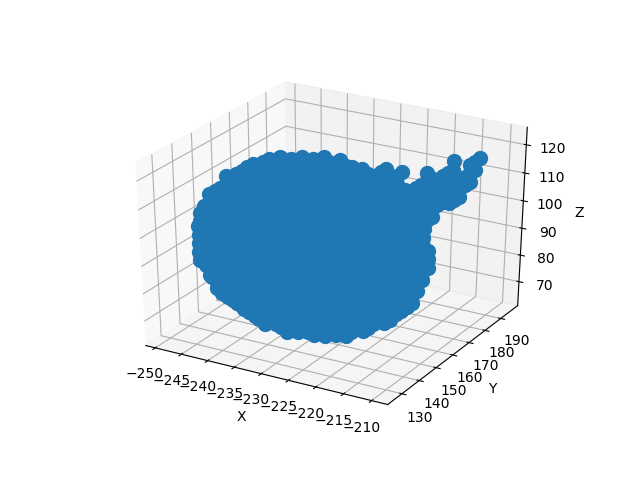

In [4]:
x_vox_ind,y_vox_ind,z_vox_ind=np.where(vox==1)
x_vox = x_pos[x_vox_ind]
y_vox = y_pos[y_vox_ind]
z_vox = z_pos[z_vox_ind]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vox, y_vox, z_vox,depthshade=False,s=100)
ax.set_zlabel('Z')
ax.set_ylabel('Y')
ax.set_xlabel('X')

plt.show()
